In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import argparse
import os
import json
import shutil

In [19]:
trans = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.ImageFolder(root="./flatfish/train", transform=trans)
validset = torchvision.datasets.ImageFolder(root="./flatfish/validation", transform=trans)
testset = torchvision.datasets.ImageFolder(root="./flatfish/test", transform=trans)

In [20]:
#18번째 데이터 확인, -1부터 1 사이 값으로 정규화된 것을 확인할 수 있음. 라벨값은 0
trainset.__getitem__(1)

(tensor([[[ 0.4196,  0.3412,  0.3412,  ..., -0.8196, -0.7882, -0.7647],
          [ 0.3961,  0.3412,  0.3725,  ..., -0.8196, -0.7882, -0.7098],
          [ 0.3725,  0.3647,  0.4196,  ..., -0.7882, -0.7176, -0.6471],
          ...,
          [ 0.2471,  0.2235,  0.2314,  ..., -0.9216, -0.8902, -0.8510],
          [ 0.2078,  0.1843,  0.2157,  ..., -0.9059, -0.8902, -0.8667],
          [ 0.2314,  0.1922,  0.2078,  ..., -0.8902, -0.8824, -0.8824]],
 
         [[-0.1294, -0.0667, -0.0902,  ..., -0.8510, -0.7804, -0.6471],
          [-0.1137, -0.0980, -0.1216,  ..., -0.8588, -0.7804, -0.5922],
          [-0.1059, -0.1373, -0.1608,  ..., -0.8275, -0.7098, -0.5059],
          ...,
          [ 0.1373,  0.1137,  0.1216,  ..., -0.9451, -0.9137, -0.8745],
          [ 0.0980,  0.0745,  0.1059,  ..., -0.9294, -0.9137, -0.8902],
          [ 0.1216,  0.0824,  0.0980,  ..., -0.9137, -0.9059, -0.9059]],
 
         [[-0.8667, -0.9137, -0.9294,  ..., -0.9373, -0.8196, -0.4275],
          [-0.9451, -0.8824,

In [21]:
#trainset 개수 확인
print(len(trainset), len(validset), len(testset))

10 4 4


In [22]:
#양식(farmed)과 자연산(natural) 클래스 구분
classes = trainset.classes
classes

['farmed', 'natural']

In [23]:
train_loader = DataLoader(trainset, batch_size = len(trainset), shuffle = True, num_workers = 4)
valid_loader = DataLoader(validset, batch_size = len(validset), shuffle = True, num_workers = 4)
test_loader = DataLoader(testset, batch_size = len(testset), shuffle = True, num_workers = 4)

In [24]:
dataiter = iter(train_loader)
train_images, train_labels = dataiter.next()
dataiter = iter(valid_loader)
valid_images, valid_labels = dataiter.next()
dataiter = iter(test_loader)
test_images, test_labels = dataiter.next()

In [25]:
print(train_labels, valid_labels, test_labels)

tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1]) tensor([0, 1, 0, 1]) tensor([0, 1, 1, 0])


In [26]:
#배치사이즈, RGB, 가로길이, 세로길이
print(train_images.shape)

torch.Size([10, 3, 200, 200])


In [27]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    
    print((np.transpose(np_img, (1,2,0))))

[[[0.8745098  0.8745098  0.8745098 ]
  [0.8745098  0.8745098  0.8745098 ]
  [0.8745098  0.8745098  0.8745098 ]
  ...
  [0.7490196  0.74509805 0.7254902 ]
  [0.7607843  0.75686276 0.7372549 ]
  [0.77254903 0.76862746 0.7490196 ]]

 [[0.8745098  0.8745098  0.8745098 ]
  [0.8745098  0.8745098  0.8745098 ]
  [0.8745098  0.8745098  0.8745098 ]
  ...
  [0.7490196  0.74509805 0.7254902 ]
  [0.7411765  0.7372549  0.7176471 ]
  [0.74509805 0.7411765  0.72156864]]

 [[0.8745098  0.8745098  0.8745098 ]
  [0.8745098  0.8745098  0.8745098 ]
  [0.8745098  0.8745098  0.8745098 ]
  ...
  [0.7529412  0.7490196  0.7294118 ]
  [0.72156864 0.7176471  0.69803923]
  [0.7058824  0.7019608  0.68235296]]

 ...

 [[0.84705883 0.85490197 0.84313726]
  [0.8509804  0.85882354 0.84705883]
  [0.8509804  0.85882354 0.84705883]
  ...
  [0.7058824  0.69411767 0.6666667 ]
  [0.70980394 0.69803923 0.67058825]
  [0.7058824  0.69411767 0.6666667 ]]

 [[0.84705883 0.85490197 0.84313726]
  [0.8509804  0.85882354 0.84705883]


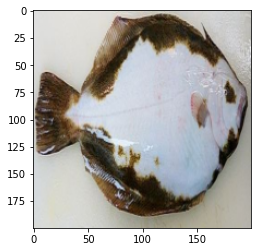

In [28]:
imshow(train_images[2])

In [29]:
class SiameseNet(nn.Module):
    
    def __init__(self):
        super(SiameseNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(inplace=True),  # 128@42*42
            nn.MaxPool2d(2),  # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(inplace=True),  # 128@18*18
            nn.MaxPool2d(2),  # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(inplace=True),  # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

        # weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def sub_forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # compute l1 distance
        diff = torch.abs(h1 - h2)

        # score the similarity between the 2 encodings
        scores = self.out(diff)

        # return scores (without sigmoid) and use bce_with_logit
        # for increased numerical stability
        return scores

In [30]:
model = SiameseNet()

In [31]:
# Define your execution device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 
model.to(device)    # Convert model parameters and buffers to CPU or Cuda 

The model will be running on cpu device



SiameseNet(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (liner): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)

In [32]:
num_epochs = 100

In [35]:
# Training Function 
best_accuracy = 0.0 
     
print("Begin training...") 
for epoch in range(1, num_epochs+1): 
    running_train_loss = 0.0 
    running_accuracy = 0.0 
    running_vall_loss = 0.0 
    total = 0 
    
    # Training Loop
    for (x1, x2) in train_loader:
    #for data in enumerate(train_loader, 0): 
        out = model(x1, x2) 
        optimizer.zero_grad()   # zero the parameter gradients          
        predicted_outputs = model(inputs)   # predict output from the model 
        train_loss = loss_fn(predicted_outputs, outputs)   # calculate loss for the predicted output  
        train_loss.backward()   # backpropagate the loss 
        optimizer.step()        # adjust parameters based on the calculated gradients 
        running_train_loss +=train_loss.item()  # track the loss value 
 
    # Calculate training loss value 
    train_loss_value = running_train_loss/len(train_loader) 
 
    # Validation Loop 
    with torch.no_grad(): 
        model.eval() 
        for data in validate_loader: 
            inputs, outputs = data 
            predicted_outputs = model(inputs) 
            val_loss = loss_fn(predicted_outputs, outputs) 
             
            # The label with the highest value will be our prediction 
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 
 
    # Calculate validation loss value 
    val_loss_value = running_vall_loss/len(validate_loader) 
                
    # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
    accuracy = (100 * running_accuracy / total)     
 
    # Save the model if the accuracy is the best 
    if accuracy > best_accuracy: 
        saveModel() 
        best_accuracy = accuracy 
         
    # Print the statistics of the epoch 
    print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

Begin training...


RuntimeError: Given groups=1, weight of size [64, 1, 10, 10], expected input[1, 3, 200, 200] to have 1 channels, but got 3 channels instead